In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve
)
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn import tree
%matplotlib inline

In [28]:
df = pd.read_csv("/Users/macbook/Desktop/internship/data/Iris.csv")
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
df.head()

Dataset Shape: (129, 5)

First 5 Rows:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [29]:

# Check for missing values
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [30]:
#check number of classes in label
pd.unique(df['species'])

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [31]:
# Preprocessing
# Encode target variable
if df['species'].dtype == 'object':
    le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])


In [32]:
#check encoded classes
pd.unique(df['species'])

array([0, 1, 2])

In [33]:
#check for dataset imbalance
print('number of samples in each class:')
df['species'].value_counts()

number of samples in each class:


species
0    50
1    50
2    29
Name: count, dtype: int64

In [34]:
#balancing dataset
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['species']), y=df['species'])
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(df['species']), class_weights)}

# Compute sample weights for each instance
sample_weights = compute_sample_weight(class_weight=class_weights_dict, y=df['species'])

In [35]:
class_weights_dict

{np.int64(0): np.float64(0.86),
 np.int64(1): np.float64(0.86),
 np.int64(2): np.float64(1.4827586206896552)}

In [36]:
from sklearn.model_selection import train_test_split
# Split features and target
X = df.drop('species', axis=1)
y = df['species']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Train-test split
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X_scaled, y, sample_weights, test_size=0.3, stratify=y, random_state=42)


In [38]:
# Summary of numeric columns
df.describe()

,sepal_length,sepal_width,petal_length,petal_width,species
count,129.000000,129.000000,129.000000,129.000000,129.000000
mean,5.716279,3.057364,3.476744,1.062791,0.837209
std,0.794983,0.453075,1.739231,0.727804,0.768427
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.500000,0.200000,0.000000
50%,5.600000,3.000000,4.000000,1.200000,1.000000
75%,6.300000,3.400000,4.800000,1.600000,1.000000
max,7.700000,4.400000,6.900000,2.500000,2.000000


In [39]:
df['petal_width'].value_counts()

petal_width
0.2    28
1.3    13
1.5    11
1.8     9
0.3     7
0.4     7
1.0     7
1.4     7
0.1     6
1.2     5
2.1     5
2.0     4
1.1     3
1.6     3
2.3     3
2.5     2
1.9     2
1.7     2
2.2     2
0.5     1
0.6     1
2.4     1
Name: count, dtype: int64

In [40]:
# Multi-Class Classification without dataset balancing
# Logistic Regression (One-vs-Rest)
lr_ovr = OneVsRestClassifier(LogisticRegression())
lr_ovr.fit(X_train, y_train)
y_pred_lr_ovr = lr_ovr.predict(X_test)

print("\nLogistic Regression (One-vs-Rest) Performance:")
print(classification_report(y_test, y_pred_lr_ovr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_ovr))


Logistic Regression (One-vs-Rest) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.87      0.90        15
           2       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.91        39
weighted avg       0.93      0.92      0.92        39

Confusion Matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  1  8]]


In [41]:
from sklearn import set_config
# Enable metadata routing for OneVsRestClassifier
set_config(enable_metadata_routing=True)

# Train model with sample weights using OneVsRestClassifier with Logistic Regression
clf = OneVsRestClassifier(LogisticRegression(class_weight=class_weights_dict, max_iter=10000))
clf.estimator.set_fit_request(sample_weight=True)  # Explicitly request sample_weight
clf.fit(X_train, y_train, sample_weight=sw_train)

y_pred = clf.predict(X_test)

# Classification Report and Confusion Matrix
print("\nLogistic Regression (One-vs-Rest) Performance balanced weights:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Logistic Regression (One-vs-Rest) Performance balanced weights:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.60      0.75        15
           2       0.60      1.00      0.75         9

    accuracy                           0.85        39
   macro avg       0.87      0.87      0.83        39
weighted avg       0.91      0.85      0.85        39

Confusion Matrix:
[[15  0  0]
 [ 0  9  6]
 [ 0  0  9]]


In [50]:
# Softmax Regression (Multinomial Logistic Regression)
softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs')
softmax.fit(X_train, y_train)
y_pred_softmax = softmax.predict(X_test)

print("\nSoftmax Regression Performance:")
print(classification_report(y_test, y_pred_softmax))


Softmax Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [42]:
# Logistic Regression (One-vs-One)
lr_ovo = OneVsOneClassifier(LogisticRegression())
lr_ovo.fit(X_train, y_train)
y_pred_lr_ovo = lr_ovo.predict(X_test)

print("\nLogistic Regression (One-vs-One) Performance:")
print(classification_report(y_test, y_pred_lr_ovo))


Logistic Regression (One-vs-One) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39



In [43]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, y_proba=None):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    if y_proba is not None:
        print("Log Loss:", log_loss(y_true, y_proba))
        print("ROC AUC Score (OvR):", roc_auc_score(y_true, y_proba, multi_class='ovr'))


In [44]:
# Evaluate Logistic Regression (OvR)
evaluate_model(y_test, y_pred_lr_ovr, lr_ovr.predict_proba(X_test))

Confusion Matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.87      0.90        15
           2       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.91        39
weighted avg       0.93      0.92      0.92        39

Log Loss: 0.31997430412578065
ROC AUC Score (OvR): 0.9817901234567902


In [45]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\nDecision Tree Performance:")
evaluate_model(y_test, y_pred_dt, dt.predict_proba(X_test))


Decision Tree Performance:
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Log Loss: 0.9241962407465937
ROC AUC Score (OvR): 0.9745370370370371


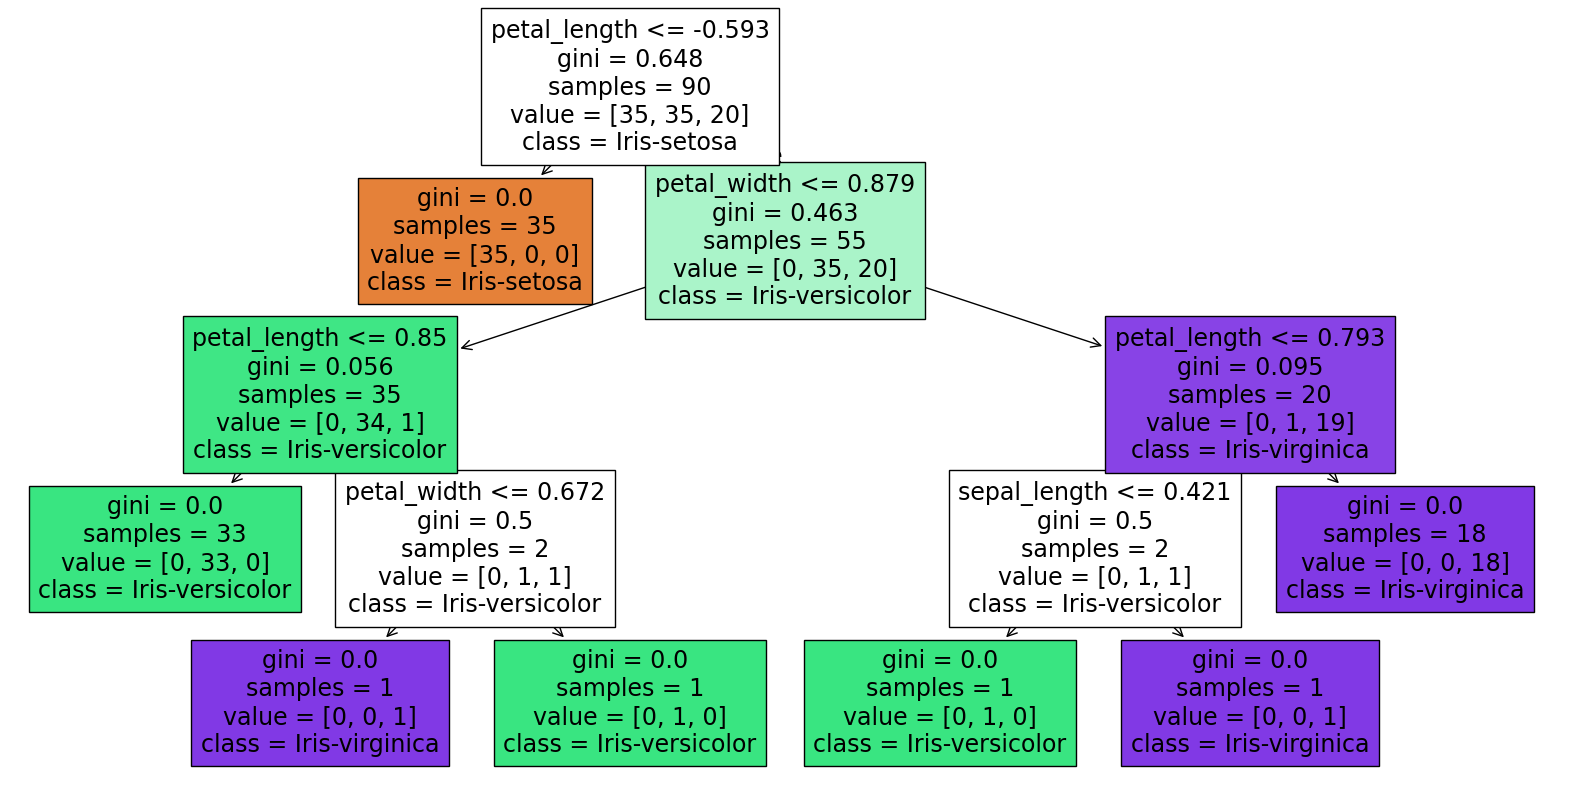

In [46]:
# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=le.classes_)
plt.show()


In [47]:
# Hyperparameter Tuning (Decision Tree)
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("\nBest Parameters for Decision Tree:")
print(grid_search.best_params_)


Best Parameters for Decision Tree:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [48]:
#Evaluate tuned Decision Tree
best_dt = grid_search.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)

print("\nTuned Decision Tree Performance:")
evaluate_model(y_test, y_pred_best_dt, best_dt.predict_proba(X_test))


Tuned Decision Tree Performance:
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Log Loss: 0.9419692453763359
ROC AUC Score (OvR): 0.9734567901234569


In [53]:
# Model Comparison
models = {
    'Logistic Regression (OvR)': lr_ovr,
    'Logistic Regression (OvO)': lr_ovo,
    'Softmax Regression': softmax,
    'Decision Tree': dt
}

metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    # Check if the model is OneVsOneClassifier
    if name == 'Logistic Regression (OvO)':
        # OneVsOneClassifier does not support predict_proba
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': 'Not Available',
            'ROC AUC (OvR)': 'Not Available'
        })
    else:
        # For other models, calculate predict_proba
        y_proba = model.predict_proba(X_test)
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': log_loss(y_test, y_proba),
            'ROC AUC (OvR)': roc_auc_score(y_test, y_proba, multi_class='ovr')
        })

metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
metrics_df
  
        

   

    


Model Comparison:


,Model,Accuracy,Precision,Recall,F1,Log Loss,ROC AUC (OvR)
0,Logistic Regression (OvR),0.923077,0.926374,0.923077,0.923775,0.319974,0.98179
1,Logistic Regression (OvO),0.974359,0.975962,0.974359,0.974018,Not Available,Not Available
2,Softmax Regression,0.974359,0.975962,0.974359,0.974018,0.15615,1.0
3,Decision Tree,0.974359,0.975962,0.974359,0.974018,0.924196,0.974537
